<a href="https://colab.research.google.com/github/pbhag/Thinkful/blob/master/pbhag/Thinkful/Shoe%20Recommender/Shoe_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product recommendation based on visual similarity

- The goal of this project is to create a recommendation system based on similar looking products
- Analogous to a "you may like" section
- If a customer is showing interest towards a shoe by browsing its page, they may also be interested in similar looking shoes

## Process mapping:
- Source images and product metadata from [UT-Zappos-50k Dataset](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/)
  -  A large shoe dataset consisting of 50,025 catalog images collected from Zappos.com, along with metadata of each shoe image, such as gender, material, etc. 
- Use transfer learning with pre-trained CNN models from Keras to extract image features
- Compute similarities between different products using previously extracted image features


In [0]:
from google.colab import drive

### 0. Imports and data setup

In [0]:
#Importing the required libraries
!pip install mat4py   #For reading the .mat files in the dataset
# Standard data manipulation libraries:
import pandas as pd
import mat4py
import numpy as np
import matplotlib.pyplot as plt

from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os

from sklearn.metrics.pairwise import cosine_similarity



Using TensorFlow backend.


Reading in the UT-Zappos50k files and creating a dataframe to hold all the shoe metadata, along with image paths:

In [0]:
image_paths = mat4py.loadmat('/content/drive/My Drive/Colab Notebooks/Shoe Recommender/image-path.mat')
image_path = [i[0] for i in image_paths['imagepath']]
meta_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Shoe Recommender/meta-data.csv')
meta_data['path'] = image_path

In [0]:
meta_data.head()

,CID,Category,SubCategory,HeelHeight,Insole,Closure,Gender,Material,ToeStyle,path
0,100627-72,Shoes,Oxfords,NaN,Leather,Lace up,Men,Leather,Capped Toe;Round Toe,Shoes/Oxfords/Bostonian/100627.72.jpg
1,100627-255,Shoes,Oxfords,NaN,Leather,Lace up,Men,Leather,Capped Toe;Round Toe,Shoes/Oxfords/Bostonian/100627.255.jpg
2,100657-72,Shoes,Oxfords,NaN,Leather;Padded;Removable,Lace up,Men,Leather,Capped Toe;Round Toe,Shoes/Oxfords/Bostonian/100657.72.jpg
3,100657-216,Shoes,Oxfords,NaN,Leather;Padded;Removable,Lace up,Men,Leather,Capped Toe;Round Toe,Shoes/Oxfords/Bostonian/100657.216.jpg
4,101026-3,Boots,Mid-Calf,1in - 1 3/4in,Leather;Padded,Pull-on,Men,Leather;Rubber,Square Toe;Closed Toe,Boots/Mid-Calf/Durango/101026.3.jpg


In [0]:
sneakers = meta_data[meta_data["SubCategory"] == "Sneakers and Athletic Shoes"]
sneakers.head()
sneakers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12856 entries, 75 to 50024
Data columns (total 10 columns):
CID            12856 non-null object
Category       12856 non-null object
SubCategory    12856 non-null object
HeelHeight     3704 non-null object
Insole         11248 non-null object
Closure        12350 non-null object
Gender         12855 non-null object
Material       12287 non-null object
ToeStyle       3986 non-null object
path           12856 non-null object
dtypes: object(10)
memory usage: 1.1+ MB


In [0]:
mens_sneakers = sneakers[(sneakers['Gender'] == "Men")]
mens_sneakers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5228 entries, 119 to 50024
Data columns (total 10 columns):
CID            5228 non-null object
Category       5228 non-null object
SubCategory    5228 non-null object
HeelHeight     1593 non-null object
Insole         4577 non-null object
Closure        4965 non-null object
Gender         5228 non-null object
Material       5019 non-null object
ToeStyle       1479 non-null object
path           5228 non-null object
dtypes: object(10)
memory usage: 449.3+ KB


In [0]:
# Parameters Setup
imgs_path = "/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/"
imgs_model_width, imgs_model_height = 224, 224

# Number of most similar images to retrieve
nb_closest_images = 10

### 1. Loading VGG16 pre-trained model from Keras
- VGG16 is a model trained on ImageNet, a big labeled images database. 
- The full model is configured to output a prediciton of an image belonging to a class (1000 classes). The last layer is the prediction layer.
- We will remove the last layer of the CNN to get the image feature extraction layer




In [0]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### 2. Specifying the image paths

In [0]:
files = [imgs_path + x for x in mens_sneakers["path"]]

print("number of images: ", len(files))

number of images:  5228


### 3. Feeding one image into the CNN to test

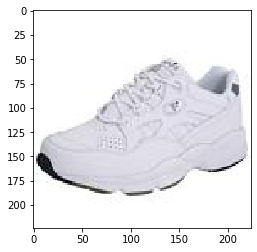

image loaded successfully!


In [0]:
# load an image in PIL format
original = load_img(files[0], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [0]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [0]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

features successfully extracted!
number of image features: 4096


array([[0.       , 0.       , 0.1253053, ..., 2.0783207, 0.       ,
        1.4158726]], dtype=float32)

### 4. Feed all mens sneakers images into the CNN

In [0]:
# load all the images and prepare them for feeding into the CNN

importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

(5228, 224, 224, 3)

In [0]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(5228, 4096)

In [0]:
size(imgs_features)

NameError: ignored

### 5. Computing Cosine Similarities
- In order to find similarities between images, we take the features of every image and compute cosine similarity metrics between every image couple

In [0]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Propet/104705.15.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Propet/104705.72.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Propet/104705.130551.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Propet/104710.3.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Reebok Lifestyle/113232.3605.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Pro-Keds/113569.2911.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Saucony/113779.5877.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Timberland PRO/115074.6370.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/adidas/115191.151.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/adidas/115191.7968.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/116001.401.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.3.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.1528.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.19673.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.40591.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.95199.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.134719.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.282804.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.326901.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.326921.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.353106.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.375233.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/New Balance Classics/117623.375234.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Rockport/118989.3.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Rockport/118989.14.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/Rockport/118989.716.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/KangaROOS/119043.815.jpg,/content/drive/My Drive/Colab Notebooks/Shoe Recommender/ut-z

###  Retrieving most similar products:

In [0]:
# function to retrieve most similar products for a given image: 

def retrieve_most_similar(given_img):

  print("-----------------------------------------------------")
  print("Original product: ")

  original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
  plt.imshow(original)
  plt.show()
  print("-----------------------------------------------------------------------")
  print("most similar products:")

  closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
  closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

  for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])
  plt.show()

-----------------------------------------------------
Original product: 


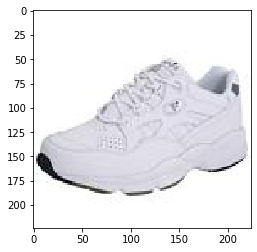

-----------------------------------------------------------------------
most similar products:


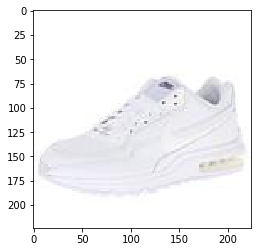

similarity score :  0.8952387


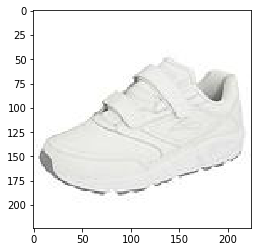

similarity score :  0.88700163


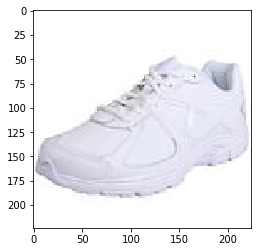

similarity score :  0.8795203


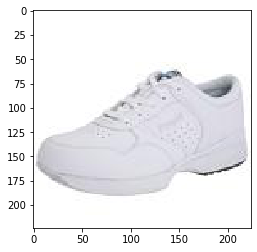

similarity score :  0.86845845


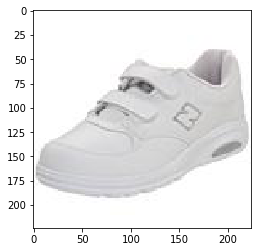

similarity score :  0.86057067


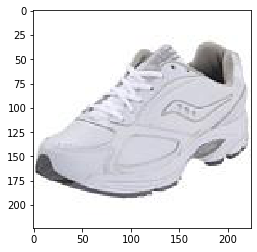

similarity score :  0.8604225


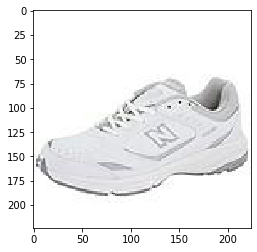

similarity score :  0.85786915


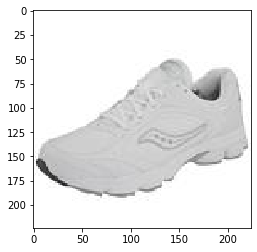

similarity score :  0.8562764


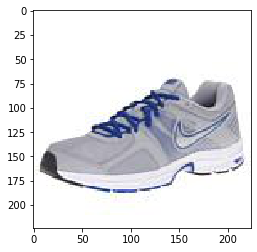

similarity score :  0.85335547


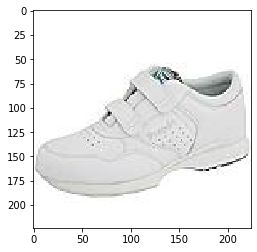

similarity score :  0.8511953


In [0]:
retrieve_most_similar(files[0])

-----------------------------------------------------
Original product: 


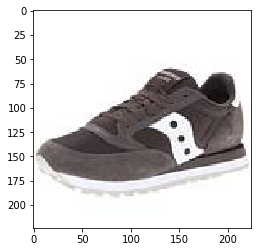

-----------------------------------------------------------------------
most similar products:


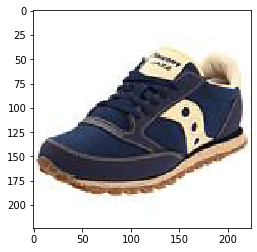

similarity score :  0.83954155


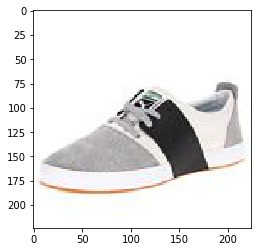

similarity score :  0.8370226


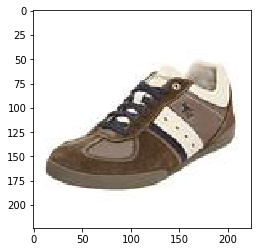

similarity score :  0.8367853


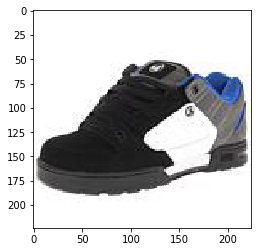

similarity score :  0.8326408


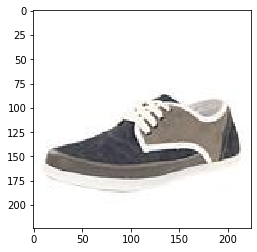

similarity score :  0.82450163


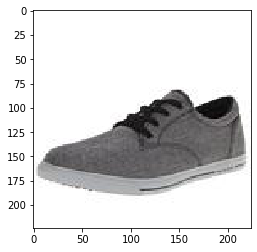

similarity score :  0.8206698


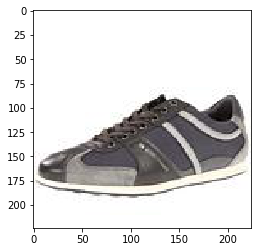

similarity score :  0.8201796


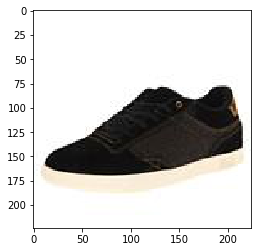

similarity score :  0.81922066


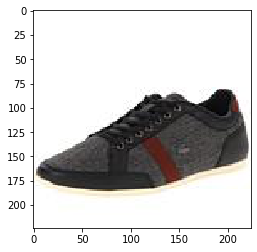

similarity score :  0.8178591


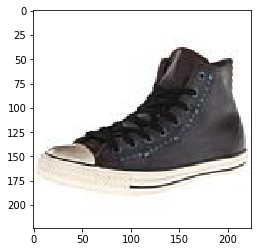

similarity score :  0.81758356


In [0]:
retrieve_most_similar(files[56])